In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)
import xgboost as xgb
import pickle

In [3]:
df = pd.read_csv("C:/Users/USER/Documents/QQQ Project/data/processed/qqq_features_classificationv2.csv",
                 index_col="Date",
                 parse_dates=["Date"])

df.head()


,ATR5,std5,norm_tr,vol_ratio_5,roc2,roc3,roc5,rsi7,MA5,MA10,close_ma5_ratio,candle_body_pct,vol_ma5,vol_spike_5,return_1d,return_2d,return_3d,target
Date,,,,,,,,,,,,,,,,,,
1999-03-23,8.066575,0.020802,0.042857,387.772095,-0.046980,-0.071344,-0.060169,41.071369,43.382503,43.478293,0.958047,4.912298,6392200.0,1.714965,-0.035207,-0.046980,-0.071344,1
1999-03-24,8.298747,0.029548,0.046541,280.859638,-0.002471,-0.014643,-0.021212,42.857116,43.196243,43.427738,0.994826,3.138638,7288600.0,1.158933,0.033931,-0.002471,-0.014643,1
1999-03-25,8.428757,0.033640,0.031395,250.554871,0.071703,0.033971,-0.004757,52.173820,43.153664,43.512883,1.032186,4.796338,7945680.0,1.023676,0.036532,0.071703,0.033971,1
1999-03-26,8.315086,0.031463,0.021276,264.279574,0.025387,0.060179,0.010372,51.063811,43.244133,43.656568,1.018952,8.332080,8164840.0,1.011189,-0.010753,0.025387,0.060179,1
1999-03-29,8.643367,0.033227,0.034905,260.131978,0.025090,0.062539,0.059913,55.483750,43.760335,43.837505,1.043415,4.213219,8182640.0,0.624957,0.036232,0.025090,0.062539,0


In [4]:
target_col = "target"

feature_cols = [
    "ATR5", "std5", "norm_tr", "vol_ratio_5",
    "roc2", "roc3", "roc5", "rsi7",
    "MA5", "MA10", "close_ma5_ratio",
    "candle_body_pct",
    "vol_ma5", "vol_spike_5",
    "return_1d", "return_2d", "return_3d"
]

X = df[feature_cols]
y = df[target_col]


In [5]:
train_df = df.loc["1999":"2018"]
test_df  = df.loc["2019":]

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test  = test_df[feature_cols]
y_test  = test_df[target_col]

X_train.shape, X_test.shape


((4977, 17), (1726, 17))

In [6]:
model = xgb.XGBClassifier(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=500,
    subsample=0.9,
    colsample_bytree=0.8,
    gamma=0.0,
    min_child_weight=1,
    objective="binary:logistic",
    eval_metric="logloss"
)

model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [7]:
pred_prob = model.predict_proba(X_test)[:, 1]   # probability UP
pred_label = (pred_prob > 0.5).astype(int)


In [8]:
print("Accuracy:", accuracy_score(y_test, pred_label))
print("Precision:", precision_score(y_test, pred_label))
print("Recall:", recall_score(y_test, pred_label))
print("F1 Score:", f1_score(y_test, pred_label))
print("AUC:", roc_auc_score(y_test, pred_prob))


Accuracy: 0.5
Precision: 0.5869565217391305
Recall: 0.5054187192118227
F1 Score: 0.5431445209105347
AUC: 0.5002833724789202


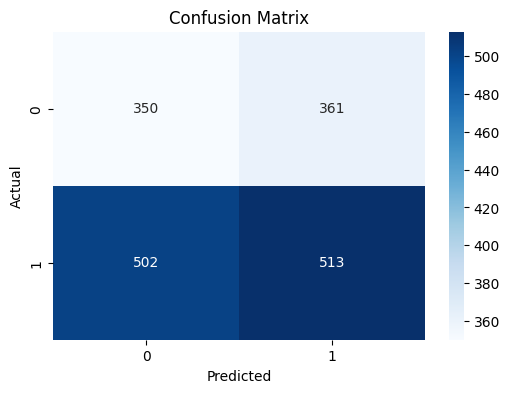

In [9]:
cm = confusion_matrix(y_test, pred_label)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


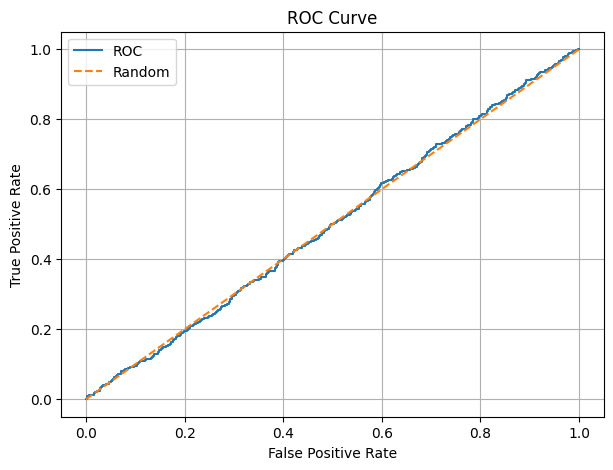

In [10]:
fpr, tpr, _ = roc_curve(y_test, pred_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label="ROC")
plt.plot([0, 1], [0, 1], '--', label="Random")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


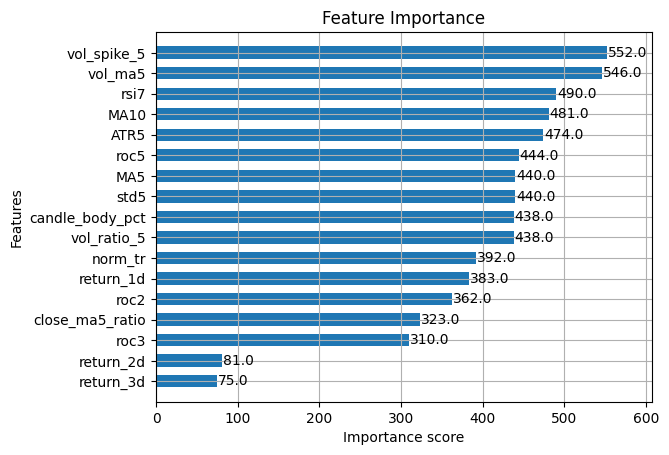

In [11]:
xgb.plot_importance(model, max_num_features=20, height=0.6)
plt.title("Feature Importance")
plt.show()


My Interpretation:
- The results improve slightly but the model is still close to random

My plan:
- Change target varibale from 3 day to 5 day.
- Do feature selection (Remove return_2d,return_3d,roc3,close_ma5_ratio)

